In [2]:
import math
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from six import StringIO
# from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["font.family"] = "Arial"
sns.set(style='whitegrid')
sns.set_palette("bright")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load Data and EDA

In [3]:
diabetes = load_diabetes()
X, y = diabetes['data'], diabetes['target']
print(diabetes['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [4]:
feature_rename = {'age': 'Age',
                  'sex': 'Sex',
                  'bmi': 'BMI',
                  'bp': 'BP',
                  's1': 'Total Cholesterol',
                  's2': 'LDL',
                  's3': 'HDL',
                  's4': 'Thyroid',
                  's5': 'Glaucoma',
                  's6': 'Glucose'}
df_data = pd.DataFrame(X, 
                       columns=diabetes['feature_names'])
df_data.rename(columns=feature_rename, inplace=True)
feature_names = list(df_data.columns.values)
df_data['target'] = y
print(feature_names)

['Age', 'Sex', 'BMI', 'BP', 'Total Cholesterol', 'LDL', 'HDL', 'Thyroid', 'Glaucoma', 'Glucose']


In [5]:
df_data.head()

Age       Sex       BMI        BP  Total Cholesterol       LDL  \
0  0.038076  0.050680  0.061696  0.021872          -0.044223 -0.034821   
1 -0.001882 -0.044642 -0.051474 -0.026328          -0.008449 -0.019163   
2  0.085299  0.050680  0.044451 -0.005670          -0.045599 -0.034194   
3 -0.089063 -0.044642 -0.011595 -0.036656           0.012191  0.024991   
4  0.005383 -0.044642 -0.036385  0.021872           0.003935  0.015596   

        HDL   Thyroid  Glaucoma   Glucose  target  
0 -0.043401 -0.002592  0.019907 -0.017646   151.0  
1  0.074412 -0.039493 -0.068332 -0.092204    75.0  
2 -0.032356 -0.002592  0.002861 -0.025930   141.0  
3 -0.036038  0.034309  0.022688 -0.009362   206.0  
4  0.008142 -0.002592 -0.031988 -0.046641   135.0

## Pearson Correlation Coefficient in Pandas

By default, the `corr()` function in pandas computes the **Pearson correlation coefficient**, which measures the **linear correlation** between two variables. The coefficient ranges from **-1 to +1**, where:

- **Magnitude > 0.7** â†’ Strong correlation  
- **0.5 â‰¤ Magnitude â‰¤ 0.7** â†’ Moderately high correlation  
- **0.3 â‰¤ Magnitude < 0.5** â†’ Low correlation  
- **Magnitude < 0.3** â†’ Little to no correlation  

This function helps analyze relationships between variables in datasets.

In [6]:
corr = df_data.corr()

In [7]:
len(df_data)

442

In [8]:
# Initializes a Matplotlib plot with a predefined size
f, ax = plt.subplots(figsize=(10, 10))
# Uses Seaborn to plot a heatmap of the correlation coefficients
sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap="PiYG",
    square=True,
    ax=ax
)
# Rotates the labels on the x-axis by 90 degrees
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);
f.savefig('images/chapter_02_feature_correlation.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_02_feature_correlation.pdf', format='pdf', dpi=300, bbox_inches='tight');

# Train/Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_train.shape

(353, 10)

In [11]:
X_test.shape

(89, 10)

In [12]:
y_train.shape

(353,)

In [13]:
y_test.shape

(89,)

# Train Linear Regression Model

## Linear Regression in Machine Learning

### Mathematical Representation
In general, the function **f** for linear regression is expressed as:

$
\text{Target Variable} = w_0 + w_1x_1 + w_2x_2 + \dots + w_nx_n
$

where:  
- $ w_0 $ is the bias term  
- $ w_1, w_2, \dots, w_n $ are the weights  
- $ x_1, x_2, \dots, x_n $ are the input features  
- $ n $ is the total number of features  

### Objective of Linear Regression
The goal of the **linear regression learning algorithm** is to determine the **weights** that best predict the target variable for all training examples. This can be achieved using:  

- **Gradient Descent**  
- **Closed-form solutions** (e.g., Newtonâ€™s Equation)  

### Why Gradient Descent?  
Gradient descent is commonly used because it **scales well** to a large number of features and training examples. The algorithm updates the weights iteratively to **minimize the squared error** between the predicted and actual target variables. Since it minimizes squared error, it is considered a **least squares-based approach**.  

### Training a Linear Regression Model in Scikit-Learn  
A linear regression model can be easily trained using **Scikit-Learn** in Python. In this example, we use the **open diabetes dataset**, which has been standardized (zero mean and unit variance for all features).  

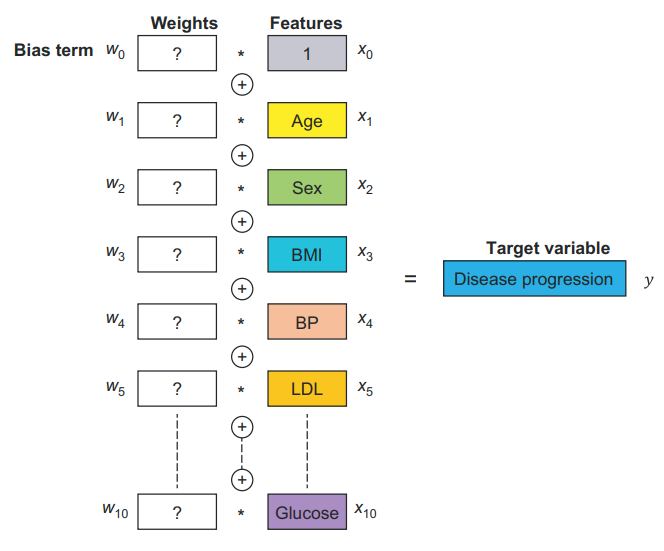

In [14]:
lr_model = LinearRegression()

In [15]:
lr_model.fit(X_train, y_train)

LinearRegression()

In [16]:
dump(lr_model, 'models/chapter_02_lr.joblib')

['models/chapter_02_lr.joblib']

# Evaluate Linear Regression Model

## Evaluating the Performance of a Linear Regression Model

The performance of a trained **linear regression model** can be quantified by comparing its predictions with the actual values in the test set. Several evaluation metrics can be used, including:

### Common Evaluation Metrics
- **Root Mean Squared Error (RMSE)**
- **Mean Absolute Error (MAE)**
- **Mean Absolute Percentage Error (MAPE)**

Each metric has its own advantages and limitations. It is useful to assess model performance using multiple metrics.

### Understanding the Metrics
- **MAE & RMSE**  
  - Both are in the same units as the target variable.  
  - Easy to interpret but do not provide a relative scale for the error.  

- **MAPE**  
  - Expresses the error as a **percentage (%)**, making it easier to interpret relative to the actual values.  
  - Useful when comparing errors across different scales.  

For example, an error of **10** may seem small at first. However, if the actual value is **100**, that error represents **10%** of the true value, which might be significant. This is where **MAPE** helps in understanding relative differences.


In [17]:
lr_model = load('models/chapter_02_lr.joblib')

In [18]:
y_pred = lr_model.predict(X_test)

In [19]:
mae = np.mean(np.abs(y_test - y_pred))
print(mae)

42.79409467959994


In [20]:
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

53.853445836765914


In [21]:
mape = np.mean(np.abs(y_test - y_pred) / y_test) * 100
print(mape)

37.49982636756112


If the **RMSE** is **53.85** and the **MAPE** is **37.50%**, here's how to interpret these results:  

- **RMSE (53.85)**: On average, the model's predictions deviate from the actual values by approximately **53.85 units** in absolute terms. Since RMSE is in the same units as the target variable, it provides a straightforward measure of error magnitude.  
- **MAPE (37.50%)**: The model's predictions have an average error of **37.50%** relative to the actual values. This means that, on average, the modelâ€™s predictions are off by about **37.5%** of the true values, which is relatively high and suggests room for improvement.  

 # Interpret Linear Regression Model

In [22]:
print(feature_names)

['Age', 'Sex', 'BMI', 'BP', 'Total Cholesterol', 'LDL', 'HDL', 'Thyroid', 'Glaucoma', 'Glucose']


In [23]:
# Obtains the weights from the linear regression model trained earlier using the coef_ parameter
weights = lr_model.coef_

In [24]:
weights

array([  37.90402135, -241.96436231,  542.42875852,  347.70384391,
       -931.48884588,  518.06227698,  163.41998299,  275.31790158,
        736.1988589 ,   48.67065743])

In [25]:
# Sorts the weights in descending order of importance and gets their indices
feature_importance_idx = np.argsort(np.abs(weights))[::-1]
feature_importance = [feature_names[idx] for idx in feature_importance_idx]
feature_importance_values = [weights[idx] for idx in feature_importance_idx]
f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=feature_importance_values, y=feature_importance, ax=ax)
ax.grid(True)
ax.set_xlabel('Feature Weights')
ax.set_ylabel('Features')
f.savefig('images/chapter_02_linear_regression_feature_importance.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_02_linear_regression_feature_importance.pdf', format='pdf', dpi=300, bbox_inches='tight');

## Limitations of Linear Regression

Linear regression is **easy to interpret** and highly transparent, making it a popular choice for modeling relationships between variables. However, it has significant **limitations**, especially when dealing with **nonlinear relationships**.

### Key Limitations:
1. **Poor Predictive Power for Nonlinear Relationships**  
   - Linear regression assumes a **linear relationship** between input features and the target variable.  
   - If the data follows a **nonlinear pattern**, a linear model will fail to capture it accurately.  

2. **Underfitting & High Bias**  
   - When a linear model is applied to nonlinear data, it produces a **straight-line fit**, which may not properly represent the data.  
   - This results in **underfitting**, where the model **fails to learn** the underlying pattern.  
   - An underfitted model has **high bias**, meaning it oversimplifies the problem and lacks predictive power.


### Overcoming the Limitations
To handle **nonlinear relationships**, we can use more **complex models** with higher predictive power, such as:
- **Polynomial Regression**  
- **Decision Trees & Random Forests**  
- **Support Vector Machines (SVMs)**  
- **Neural Networks**  

In the next sections, we will explore these **alternative models** to improve predictive performance. ðŸš€  


# Train Decision Tree Model

## Classification and Regression Tree (CART) Algorithm

The **CART (Classification and Regression Tree) algorithm** is commonly used to determine **optimum splits** when building decision trees. It works by selecting a **feature** and an **optimal threshold** to split the dataset.

### How CART Splits the Data
The algorithm splits the dataset into two subsets based on a selected **feature** and **threshold**:
- **Subset 1**: Instances where the feature value is **â‰¤ threshold**  
- **Subset 2**: Instances where the feature value is **> threshold**  

### How the Algorithm Chooses the Best Split
CART selects the **feature and threshold** that minimizes a predefined **cost function (criterion)**:

- **For Regression**: The criterion is typically **Mean Squared Error (MSE)**.  
- **For Classification**: The criterion is usually **Gini impurity** or **Entropy**.  

### Recursive Splitting
The algorithm continues to **recursively** split the data until:
- The cost function is minimized further.  
- A **maximum depth** is reached (to prevent overfitting).  

This recursive process results in a **tree structure**, which can then be used for making predictions in both **classification** and **regression** tasks.



In [26]:
dt_model = DecisionTreeRegressor(max_depth=None, random_state=42)
dt_model_depth3 = DecisionTreeRegressor(max_depth=3, random_state=42)

In [27]:
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [28]:
dt_model_depth3.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [29]:
dump(dt_model, 'models/chapter_02_dt.joblib');
dump(dt_model_depth3, 'models/chapter_02_dt_depth3.joblib');

# Evaluate Decision Tree Model

In [30]:
dt_model = load('models/chapter_02_dt.joblib')
dt_model_depth3 = load('models/chapter_02_dt_depth3.joblib')

In [31]:
y_pred = dt_model.predict(X_test)

In [32]:
mae = np.mean(np.abs(y_test - y_pred))
print(mae)

54.52808988764045


In [33]:
y_pred_depth3 = dt_model_depth3.predict(X_test)

In [34]:
mae_depth3 = np.mean(np.abs(y_test - y_pred_depth3))
print(mae_depth3)

48.0965923002249


In [35]:
rmse_depth3 = math.sqrt(mean_squared_error(y_test, y_pred_depth3))
print(rmse_depth3)

59.60454104616319


In [36]:
mape_depth3 = np.mean(np.abs(y_test - y_pred_depth3) / y_test) * 100
print(mape_depth3)

43.0691295558855


# Interpret Decision Tree Model

## Interpreting a Learned Nonlinear Function in Decision Trees

### Understanding Decision Tree Interpretability
A **decision tree** can be visualized as a series of **if-else conditions**, where each condition **splits the dataset** into two subsets. This structure allows for easy **interpretability**, as it can be represented as a **binary tree**.

### How to Interpret a Decision Tree  
Starting at the **root node**, we follow the conditions down the tree:

1. **Root Node Check (100% of Data)**  
   - The first split is based on **normalized BMI**.  
   - If `BMI â‰¤ 0`, move to the **left** child node.  
   - If `BMI > 0`, move to the **right** child node.  
   - If we set `max_depth = 0`, the model predicts **153.7** (average value of all samples) with an **MSE of 6076.4**.

2. **Next Splits**  
   - If `BMI â‰¤ 0`, check if **Glucose â‰¤ 0**.  
   - This subset accounts for **~59%** of the data.  
   - The **MSE reduces** from **6076.4 to 3612.7**.  

3. **Final Leaf Node Example**  
   - If `BMI > 0`, `BMI > 0.1`, and `LDL > 0`, then predict **225.8**.  
   - This accounts for **2.3%** of the data, with an **MSE of 2757.9**.  

### Effect of Tree Depth (`max_depth`) 
- Increasing `max_depth` makes the tree **more complex**, improving its ability to capture **patterns**, but may also lead to **overfitting**.  

---


In [37]:
print(feature_names)

['Age', 'Sex', 'BMI', 'BP', 'Total Cholesterol', 'LDL', 'HDL', 'Thyroid', 'Glaucoma', 'Glucose']


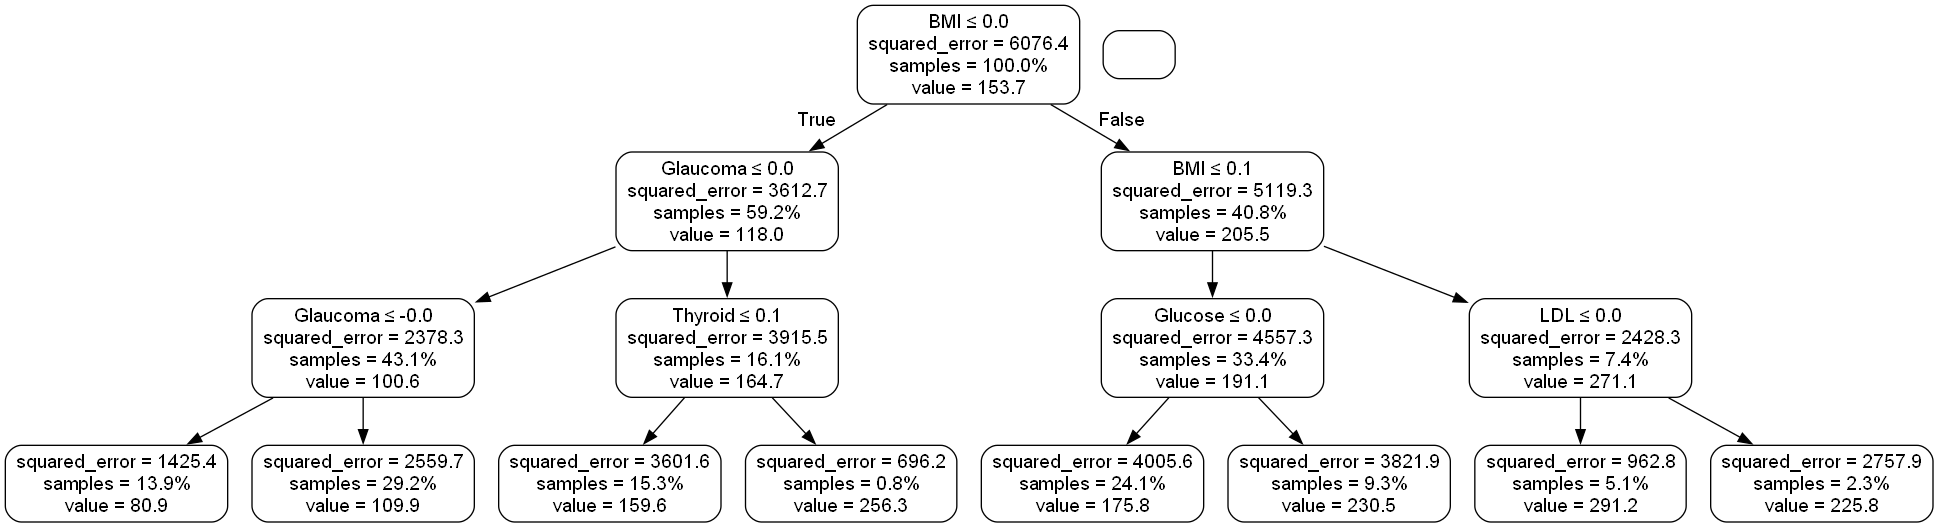

In [40]:
# Initializes a string buffer to store the binary tree/graph in DOT format
diabetes_dt_dot_data = StringIO()
# Exports the decision tree model as a binary tree in DOT format
export_graphviz(dt_model_depth3, 
                out_file=diabetes_dt_dot_data,
                filled=False, rounded=True,
                feature_names=feature_names,
                proportion=True,
                precision=1,
                special_characters=True)
# Generates an image of the binary tree using the DOT format string
dt_graph = pydotplus.graph_from_dot_data(diabetes_dt_dot_data.getvalue())  
dt_graph.write_png('images/chapter_02_decision_tree.png')
dt_graph.write_svg('images/chapter_02_decision_tree.svg')
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF
drawing = svg2rlg('images/chapter_02_decision_tree.svg')
renderPDF.drawToFile(drawing, 'images/chapter_02_decision_tree.pdf')
# Visualizes the binary tree using the Image class
Image(dt_graph.create_png())

## Understanding Feature Importance in Decision Trees

### Why is Feature Importance Needed?
Unlike **linear regression**, where the impact of each feature is **explicitly interpretable**, decision trees learn **nonlinear relationships**, making it harder to understand how changes in inputs affect the output.  

However, we can still compute the **relative importance** of each feature in predicting the target **at a global level**.

### How Feature Importance is Computed
To determine the importance of each feature, we follow these steps:

1. **Compute Node Importance**  
   - The importance of a **node** in the decision tree is calculated as:  
     - The **decrease in the cost function** (e.g., **MSE for regression** or **Gini impurity for classification**) at that node.  
     - This decrease is **weighted** by the probability of **reaching that node**.

2. **Aggregate Feature Importance**  
   - The importance of a feature is computed by summing the importance of all nodes where the feature is used for splitting.  
   - The final feature importances are then **normalized** so that they sum to **1**.

---


In [41]:
# Gets feature importance from the trained decision tree model
weights = dt_model.feature_importances_
# Sorts indices of feature weights in descending order of importance
feature_importance_idx = np.argsort(np.abs(weights))[::-1]
feature_importance = [feature_names[idx] for idx in feature_importance_idx]
feature_importance_values = [weights[idx] for idx in feature_importance_idx]
f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=feature_importance_values, y=feature_importance, ax=ax)
ax.grid(True)
ax.set_xlabel('Feature Weights')
ax.set_ylabel('Features')
f.savefig('images/chapter_02_decision_tree_feature_importance.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_02_decision_tree_feature_importance.pdf', format='pdf', dpi=300, bbox_inches='tight');

# Underfitting vs Overfitting

## Limitations of Decision Trees

### Strengths of Decision Trees
Decision trees are **versatile** because:
- They can be applied to both **regression** and **classification** tasks.
- They can model **nonlinear relationships** between input features and the target variable.

However, decision trees also have **significant limitations**, particularly the risk of **overfitting**.

---

### Overfitting and High Variance
One of the major drawbacks of decision trees is that they are **prone to overfitting**, leading to **high variance** in the model.

#### What is Overfitting?
- Overfitting occurs when a model **fits the training data too well**, capturing even noise.
- As a result, it performs **poorly on unseen data (test set)**.

#### Example: Overfitting in the Diabetes Dataset
- The decision tree model trained on the **diabetes dataset** performed **worse than linear regression**.
- This is likely due to overfitting, where the model **memorized** patterns in the training set but failed to generalize.

---

### How to Prevent Overfitting in Decision Trees
We can **reduce overfitting** by tuning **hyperparameters**, such as:

1. **`max_depth`**  
   - Limits the depth of the tree to prevent excessive splits.
   - Example: `max_depth=3`


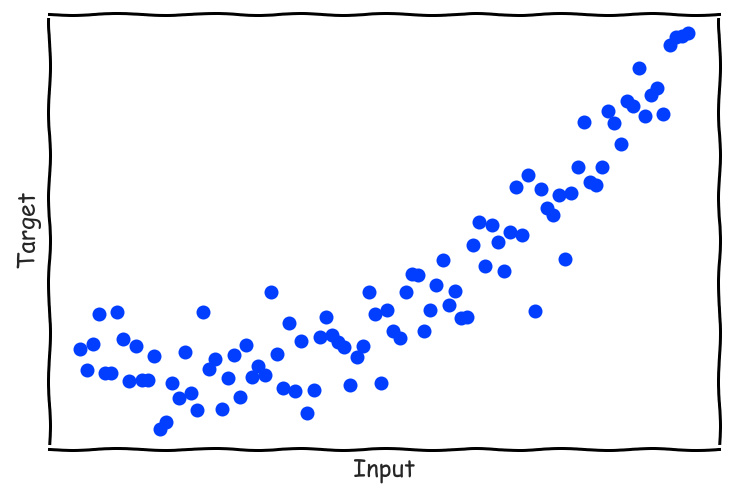

In [44]:
np.random.seed(42)
n_samples = 100

X = np.linspace(0, 10, 100)
rng = np.random.randn(n_samples) * 100

y = 2 * X**0.5 + X ** 3 + rng + 100

# Non-linear data
with plt.xkcd():
    f, ax = plt.subplots()
    ax.scatter(X, y)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Input')
    ax.set_ylabel('Target')
    f.savefig('images/chapter_02_nonlinear_data.png', dpi=300, bbox_inches='tight');
    f.savefig('images/chapter_02_nonlinear_data.pdf', format='pdf', dpi=300, bbox_inches='tight');
#     ax.set_title('Non-Linear Data')

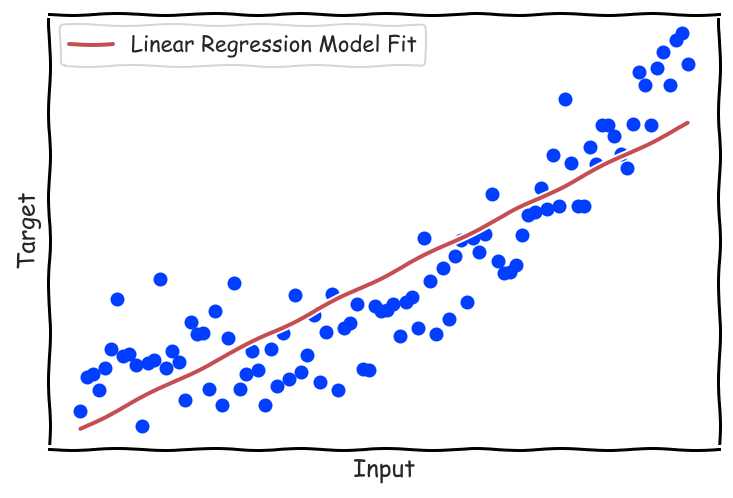

In [45]:
X = np.linspace(0, 10, 100)
rng = np.random.randn(n_samples) * 100

y = 2 * X**0.5 + X ** 3 + rng + 100
lr = LinearRegression()
lr.fit(X.reshape(-1, 1), y)
model_pred = lr.predict(X.reshape(-1,1))
# Underfitting
with plt.xkcd():
    f, ax = plt.subplots()
    ax.scatter(X, y)
    ax.plot(X, model_pred, 'r-', label='Linear Regression Model Fit');
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Input')
    ax.set_ylabel('Target')
    ax.legend()
    f.savefig('images/chapter_02_underfitting.png', dpi=300, bbox_inches='tight');
    f.savefig('images/chapter_02_underfitting.pdf', format='pdf', dpi=300, bbox_inches='tight');

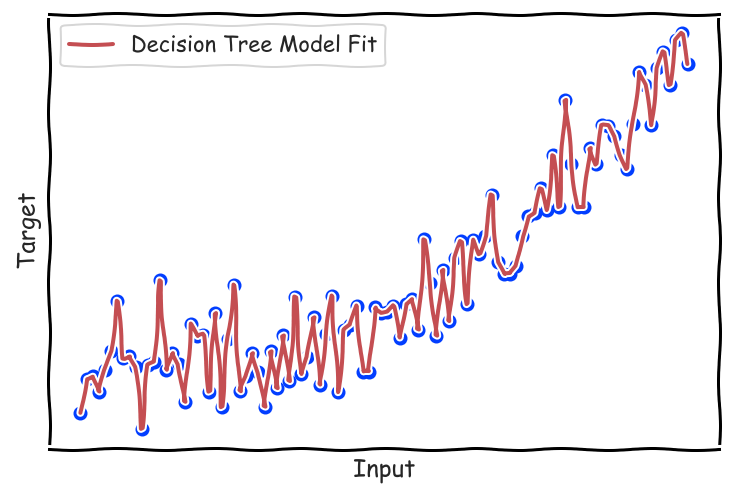

In [46]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X.reshape(-1, 1), y)
model_pred = dt.predict(X.reshape(-1,1))
# Underfitting
with plt.xkcd():
    f, ax = plt.subplots()
    ax.scatter(X, y)
    ax.plot(X, model_pred, 'r-', label='Decision Tree Model Fit');
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Input')
    ax.set_ylabel('Target')
    ax.legend()
    f.savefig('images/chapter_02_overfitting.png', dpi=300, bbox_inches='tight');
    f.savefig('images/chapter_02_overfitting.pdf', format='pdf', dpi=300, bbox_inches='tight');